# Cloning Repo & installing libs

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Setting paths

In [64]:
countries           = [ 'South Korea', 'Cuba', 'India', 'Pakistan', 'Bangladesh']#, 'Turkey']
#countries           = ['Saudi Arabia','South Korea','India','China', 'Pakistan', 'Bangladesh', 'Argentina', 'Botswana']
primary           = "20-24-Primary_fin"
lower_secondary   = "20-24-Lower_Secondary_fin"
higher_secondary  = "20-24-Higher_Secondary_fin"
college           = "25-29-College_comp"
life_expectancy   = "life_expectancy"
gdp_per_capita    = "gdp_per_capita"
total_fertility   = "children_per_woman"
dpi               = 500 #image quality

In [52]:
def build_graph(ylabel,file_name):
  datasets_path   = load_paths()
  if toggle:
    finish_dic      = create_n_fin_dic()
    country_coords  = find_coords(finish_dic)
    plot_graph(ylabel, country_coords,file_name,finish_dic)
    rewrite_js_file()
  else:
    country_coords  = find_coords_yearly()
    plot_graph(ylabel, country_coords,file_name)
    rewrite_js_file()



In [37]:
def load_paths():
  root = "./edu_datasets/" 
  
  global datasets_path  
  datasets_path = {
                      "20-24-Primary_fin"               :  root+ "20-24-Primary_fin.csv",
                      "20-24-Lower_Secondary_fin"       :  root+ "20-24-Lower_Secondary_fin.csv",
                      "20-24-Higher_Secondary_fin"      :  root+ "20-24-Higher_Secondary_fin.csv",
                      "25-29-College_comp"              :  root+ "College_comp.csv",
                      "children_per_woman"              :  root+ "children_per_woman_total_fertility.csv",
                      "gdp_per_capita"                  :  root+ "gdppercapita_us_inflation_adjusted.csv",
                      "life_expectancy"                 :  root+ "life_expectancy_years.csv",
                  }


In [38]:
def create_n_fin_dic():
  df = pd.read_csv(datasets_path[edu_level])
  df = df[df['Country'].isin(countries)]
  end_year = 2016
  if edu_level == gdp_per_capita or edu_level == life_expectancy:
    end_year = 2021
  years = list(range(1960, end_year))
  period_dic = {country : [] for country in countries}
  for i in range(len(df)):
    started = False
    s_year  = 1960
    for year in years:
      if not started and df.iloc[i][str(year)] >= initial_comp_rate and df.iloc[i][str(year)] < final_comp_rate:
        started = True
        s_year  = year
        period_dic[df.iloc[i]['Country']].append(year)
      elif started and df.iloc[i][str(year)] >= final_comp_rate :
        period_dic[df.iloc[i]['Country']].append(year)
        break
    else:
      if started:
        period_dic[df.iloc[i]['Country']].append(year)

  return period_dic

In [6]:
def find_coords(fin_dic):
  
  df = pd.read_csv(datasets_path[edu_level])
  country_coords = {}
  for country in countries:
    if len(fin_dic[country])==2:
      s_y,e_y = fin_dic[country]
    else:
      s_y,e_y = 0,-1
    x_coords= [i for i in range(e_y-s_y+1)]
    y_coords= []
    df_c = df[df.Country==country]               
    for y in range(s_y,e_y+1):
      y_coords.append(df_c[str(y)].tolist())
    y_coords = [j for sub in y_coords for j in sub]
    if edu_level==gdp_per_capita:
      y_coords = np.log10(y_coords)
    country_coords[country] = [x_coords,y_coords]

  return country_coords

In [39]:
def find_coords_yearly():
  
  df = pd.read_csv(datasets_path[edu_level])
  country_coords = {}
  s_y,e_y=1960,2020 if edu_level == gdp_per_capita or edu_level == life_expectancy else 2015
  for country in countries:
    x_coords= [i for i in range(s_y,e_y+1)]
    y_coords= []
    df_c = df[df.Country==country]               
    for y in range(s_y,e_y+1):
      y_coords.append(df_c[str(y)].tolist())
    y_coords = [j for sub in y_coords for j in sub]
    if edu_level==gdp_per_capita:
      y_coords = np.log10(y_coords)
    country_coords[country] = [x_coords,y_coords]

  return country_coords

In [54]:
def plot_graph(ylabel, country_coords,file_name,finish_dic={}):
  for country,coords in country_coords.items():
    try:
      # print(f"{country:<20}{finish_dic[country]}")
      pass
    except:
      pass
    plt.plot(coords[0], coords[1],label=country)
  plt.ylabel(ylabel)
  if edu_level == gdp_per_capita:
    locs, labels = plt.yticks()
    labels = [round(10**float(item),2) for item in locs]
    plt.yticks(locs, labels)
  plt.legend()
  plt.tight_layout()
  plt.savefig(f'./graphs/{file_name}.png', dpi=dpi)
  # plt.show()
  


In [41]:
import os
def rewrite_js_file():
    file_names = [i for i in os.listdir('./graphs') if i.endswith('.png')]
  
    with open('./js/displayGraph.js','w') as f:
      f.write(f"var file_names = {file_names};")
      f.write("\n")
      f.write("""document.addEventListener('DOMContentLoaded', function() {

    for (var i = 0; i < file_names.length; i++) {
        var img = document.createElement("img");
        img.src = "graphs/"+file_names[i];
        img.className = 'centerImg'
        document.body.appendChild(img);
    }

     
}
);""")

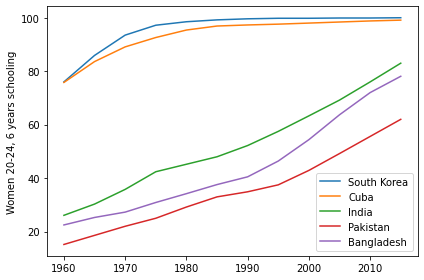

In [66]:
edu_level           = primary
initial_comp_rate   = 0
final_comp_rate     = 100
toggle              = False
build_graph('Women 20-24, 6 years schooling','1')

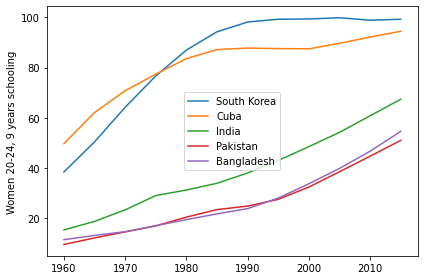

In [67]:
edu_level           = lower_secondary
initial_comp_rate   = 0
final_comp_rate     = 100
toggle              = False
build_graph('Women 20-24, 9 years schooling','2')

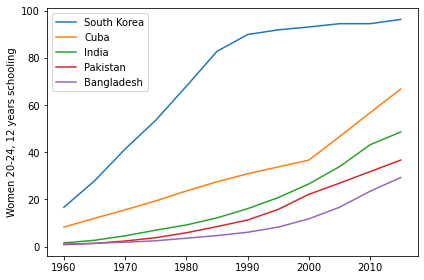

In [68]:
edu_level           = higher_secondary
initial_comp_rate   = 40
final_comp_rate     = 100
toggle              = False
build_graph('Women 20-24, 12 years schooling','3')

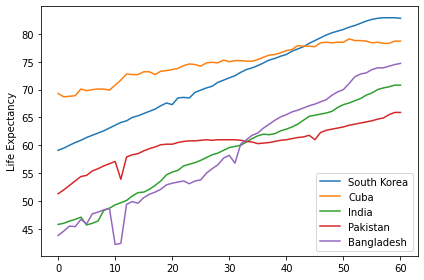

In [69]:
edu_level           = life_expectancy
initial_comp_rate   = 10
final_comp_rate     = 90

toggle              = True
build_graph('Life Expectancy','4')


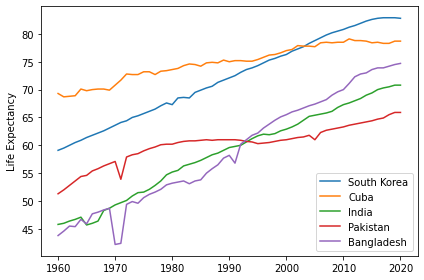

In [70]:
initial_comp_rate   = 10
final_comp_rate     = 90

toggle              = False
build_graph('Life Expectancy','5')

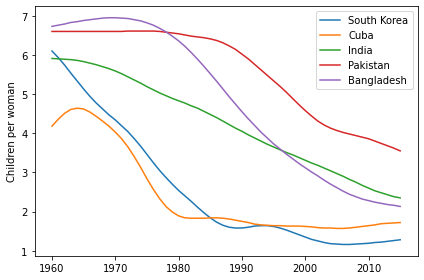

In [71]:
edu_level           = total_fertility
initial_comp_rate   = 0
final_comp_rate     = 100
toggle              = False
build_graph('Children per woman','6')

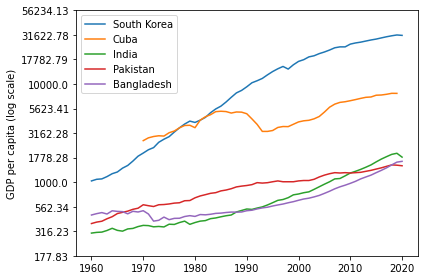

In [72]:
edu_level           = gdp_per_capita
initial_comp_rate   = 00
final_comp_rate     = 9999999
toggle              = False
build_graph('GDP per capita (log scale)','7')

In [73]:
edu_level           = college
initial_comp_rate   = 0
final_comp_rate     = 100
toggle              = False
build_graph('Women 25-29, college','8')

In [ ]:
import subprocess
subprocess.call(["git", "add", '.'])
subprocess.call(["git","commit","-m",'"added graphes"'])
subprocess.call(["git", "push"])

0